<a href="https://colab.research.google.com/github/grvrmayank/AudioAnalytics_S2-24_AIMLCZG527/blob/main/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group No: 08

### Group Member Names:

1. Vidit <>
2. Mayank Grover (2023AC05486@wilp.bits-pilani.ac.in)
3.

### Solution

In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
import librosa
import librosa.display
from matplotlib.colors import LogNorm

In [7]:
class FrequencyDomainAnalyzer:
    """
    Class for extracting frequency domain features from audio signals.
    """

    def __init__(self, sample_rate=44100):
        self.sample_rate = sample_rate

    def compute_fft(self, audio_signal, window='hann'):
        """
        Compute the Fast Fourier Transform of the audio signal.

        Parameters:
        - audio_signal: 1D numpy array
        - window: windowing function ('hann', 'hamming', 'blackman', None)

        Returns:
        - frequencies: frequency bins
        - magnitude: magnitude spectrum
        - phase: phase spectrum
        - fft_complex: complex FFT result
        """
        # Ensure signal is 1D
        if audio_signal.ndim > 1:
            audio_signal = audio_signal.flatten()

        # Apply windowing if specified
        if window is not None:
            if window == 'hann':
                win = np.hanning(len(audio_signal))
            elif window == 'hamming':
                win = np.hamming(len(audio_signal))
            elif window == 'blackman':
                win = np.blackman(len(audio_signal))
            else:
                win = np.ones(len(audio_signal))

            windowed_signal = audio_signal * win
        else:
            windowed_signal = audio_signal

        # Compute FFT
        fft_complex = np.fft.rfft(windowed_signal)

        # Frequency bins
        frequencies = np.fft.rfftfreq(len(audio_signal), 1/self.sample_rate)

        # Magnitude and phase
        magnitude = np.abs(fft_complex)
        phase = np.angle(fft_complex)

        # Normalize magnitude
        magnitude = magnitude / len(audio_signal)
        magnitude[1:-1] *= 2  # Account for one-sided spectrum

        return frequencies, magnitude, phase, fft_complex

    def compute_spectrogram(self, audio_signal, nperseg=2048, noverlap=None, window='hann'):
        """
        Compute the spectrogram using Short-Time Fourier Transform (STFT).

        Parameters:
        - audio_signal: 1D numpy array
        - nperseg: length of each segment (window size)
        - noverlap: number of overlapping samples
        - window: windowing function

        Returns:
        - frequencies: frequency bins
        - times: time bins
        - spectrogram: 2D array of magnitude spectrogram
        - phase_spectrogram: 2D array of phase spectrogram
        """
        # Ensure signal is 1D
        if audio_signal.ndim > 1:
            audio_signal = audio_signal.flatten()

        # Set default overlap
        if noverlap is None:
            noverlap = nperseg // 2

        # Compute STFT
        frequencies, times, stft_complex = signal.stft(
            audio_signal,
            fs=self.sample_rate,
            window=window,
            nperseg=nperseg,
            noverlap=noverlap,
            return_onesided=True
        )

        # Magnitude and phase spectrograms
        magnitude_spectrogram = np.abs(stft_complex)
        phase_spectrogram = np.angle(stft_complex)

        return frequencies, times, magnitude_spectrogram, phase_spectrogram, stft_complex

    def compute_mel_spectrogram(self, audio_signal, n_mels=128, fmin=0, fmax=None,
                               n_fft=2048, hop_length=512, window='hann'):
        """
        Compute Mel-scale spectrogram.

        Parameters:
        - audio_signal: 1D numpy array
        - n_mels: number of mel frequency bins
        - fmin: minimum frequency
        - fmax: maximum frequency (None = sample_rate/2)
        - n_fft: FFT window size
        - hop_length: hop size between windows
        - window: windowing function

        Returns:
        - mel_frequencies: mel frequency bins
        - times: time bins
        - mel_spectrogram: mel-scale magnitude spectrogram
        - mel_filters: mel filter bank
        """
        # Ensure signal is 1D
        if audio_signal.ndim > 1:
            audio_signal = audio_signal.flatten()

        # Set default fmax
        if fmax is None:
            fmax = self.sample_rate // 2

        # Compute mel spectrogram using librosa
        mel_spec = librosa.feature.melspectrogram(
            y=audio_signal,
            sr=self.sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            fmin=fmin,
            fmax=fmax,
            window=window
        )

        # Get mel frequencies
        mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax)

        # Time axis
        times = librosa.frames_to_time(
            np.arange(mel_spec.shape[1]),
            sr=self.sample_rate,
            hop_length=hop_length
        )

        # Get mel filter bank for visualization
        mel_filters = librosa.filters.mel(
            sr=self.sample_rate,
            n_fft=n_fft,
            n_mels=n_mels,
            fmin=fmin,
            fmax=fmax
        )

        return mel_frequencies, times, mel_spec, mel_filters

    def mel_to_hz(self, mel):
        """Convert mel frequency to Hz."""
        return 700 * (10**(mel / 2595) - 1)

    def hz_to_mel(self, hz):
        """Convert Hz to mel frequency."""
        return 2595 * np.log10(1 + hz / 700)

In [8]:
def generate_test_signal():
    """Generate a complex test signal for analysis."""

    sample_rate = 44100
    duration = 2.0
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

    # Create a complex signal with multiple components
    # 1. Fundamental frequency (440 Hz - A4)
    fundamental = 0.5 * np.sin(2 * np.pi * 440 * t)

    # 2. First harmonic (880 Hz)
    harmonic1 = 0.3 * np.sin(2 * np.pi * 880 * t)

    # 3. Second harmonic (1320 Hz)
    harmonic2 = 0.2 * np.sin(2 * np.pi * 1320 * t)

    # 4. Frequency sweep (chirp) from 200 to 2000 Hz
    chirp = 0.3 * signal.chirp(t, f0=200, f1=2000, t1=duration, method='linear')

    # 5. Add some noise
    np.random.seed(42)
    noise = 0.05 * np.random.normal(0, 1, len(t))

    # Combine all components
    # First half: harmonics, Second half: chirp
    complex_signal = np.zeros_like(t)
    mid_point = len(t) // 2

    # First half - harmonic content
    complex_signal[:mid_point] = (fundamental[:mid_point] +
                                harmonic1[:mid_point] +
                                harmonic2[:mid_point] +
                                noise[:mid_point])

    # Second half - chirp
    complex_signal[mid_point:] = chirp[mid_point:] + noise[mid_point:]

    # Apply envelope to make it more realistic
    envelope = np.exp(-((t - duration/2) / (duration/3))**2)
    complex_signal *= envelope

    return complex_signal, sample_rate, t

In [9]:
def plot_fft_analysis(audio_signal, frequencies, magnitude, phase, sample_rate, t):
    """Plot FFT analysis results."""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Time domain signal
    ax1.plot(t, audio_signal, 'b-', linewidth=1)
    ax1.set_title('Time Domain Signal')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)

    # Magnitude spectrum (linear scale)
    ax2.plot(frequencies, magnitude, 'r-', linewidth=1)
    ax2.set_title('Magnitude Spectrum (Linear Scale)')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.set_xlim(0, 3000)  # Focus on audible range
    ax2.grid(True, alpha=0.3)

    # Magnitude spectrum (log scale)
    ax3.semilogy(frequencies, magnitude + 1e-10, 'r-', linewidth=1)  # Add small value to avoid log(0)
    ax3.set_title('Magnitude Spectrum (Log Scale)')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Magnitude (Log)')
    ax3.set_xlim(0, 3000)
    ax3.grid(True, alpha=0.3)

    # Phase spectrum
    ax4.plot(frequencies, phase, 'g-', linewidth=1)
    ax4.set_title('Phase Spectrum')
    ax4.set_xlabel('Frequency (Hz)')
    ax4.set_ylabel('Phase (radians)')
    ax4.set_xlim(0, 3000)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [10]:
def plot_spectrogram_analysis(audio_signal, frequencies, times, spectrogram,
                            phase_spectrogram, sample_rate, t):
    """Plot spectrogram analysis results."""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Time domain signal
    ax1.plot(t, audio_signal, 'b-', linewidth=1)
    ax1.set_title('Time Domain Signal')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)

    # Magnitude spectrogram (linear scale)
    im1 = ax2.pcolormesh(times, frequencies, spectrogram, shading='gouraud', cmap='viridis')
    ax2.set_title('Magnitude Spectrogram (Linear Scale)')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_ylim(0, 3000)
    plt.colorbar(im1, ax=ax2, label='Magnitude')

    # Magnitude spectrogram (log scale)
    im2 = ax3.pcolormesh(times, frequencies, 20*np.log10(spectrogram + 1e-10),
                        shading='gouraud', cmap='viridis')
    ax3.set_title('Magnitude Spectrogram (dB Scale)')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Frequency (Hz)')
    ax3.set_ylim(0, 3000)
    plt.colorbar(im2, ax=ax3, label='Magnitude (dB)')

    # Phase spectrogram
    im3 = ax4.pcolormesh(times, frequencies, phase_spectrogram,
                        shading='gouraud', cmap='hsv')
    ax4.set_title('Phase Spectrogram')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Frequency (Hz)')
    ax4.set_ylim(0, 3000)
    plt.colorbar(im3, ax=ax4, label='Phase (radians)')

    plt.tight_layout()
    plt.show()

In [11]:
def plot_mel_spectrogram_analysis(audio_signal, mel_frequencies, times, mel_spec,
                                mel_filters, sample_rate, t):
    """Plot mel spectrogram analysis results."""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Time domain signal
    ax1.plot(t, audio_signal, 'b-', linewidth=1)
    ax1.set_title('Time Domain Signal')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)

    # Mel spectrogram (linear scale)
    im1 = ax2.pcolormesh(times, mel_frequencies, mel_spec, shading='gouraud', cmap='viridis')
    ax2.set_title('Mel Spectrogram (Linear Scale)')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Mel Frequency (Hz)')
    plt.colorbar(im1, ax=ax2, label='Magnitude')

    # Mel spectrogram (dB scale)
    mel_spec_db = 20 * np.log10(mel_spec + 1e-10)
    im2 = ax3.pcolormesh(times, mel_frequencies, mel_spec_db, shading='gouraud', cmap='viridis')
    ax3.set_title('Mel Spectrogram (dB Scale)')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Mel Frequency (Hz)')
    plt.colorbar(im2, ax=ax3, label='Magnitude (dB)')

    # Mel filter bank
    freq_bins = np.linspace(0, sample_rate//2, mel_filters.shape[1])
    for i in range(0, mel_filters.shape[0], 8):  # Plot every 8th filter
        ax4.plot(freq_bins, mel_filters[i], label=f'Mel {i}')
    ax4.set_title('Mel Filter Bank (Every 8th Filter)')
    ax4.set_xlabel('Frequency (Hz)')
    ax4.set_ylabel('Filter Response')
    ax4.set_xlim(0, 8000)
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    plt.tight_layout()
    plt.show()


In [17]:
def analyze_frequency_content(frequencies, magnitude, mel_frequencies, mel_spec):
    """Analyze and print frequency content statistics."""

    print("\nFrequency Analysis Results:")
    print("=" * 50)

    # FFT Analysis
    peak_indices = np.argsort(magnitude)[-5:][::-1]  # Top 5 peaks
    print("Top 5 Frequency Components (FFT):")
    for i, idx in enumerate(peak_indices):
        if magnitude[idx] > 0.01:  # Only significant peaks
            print(f"  {i+1}. {frequencies[idx]:.1f} Hz: {magnitude[idx]:.4f}")

    # Frequency statistics
    spectral_centroid = np.sum(frequencies * magnitude) / np.sum(magnitude)
    print(f"\nSpectral Centroid: {spectral_centroid:.1f} Hz")

    # Mel spectrogram analysis
    mel_energy = np.mean(mel_spec, axis=1)
    peak_mel_idx = np.argmax(mel_energy)
    print(f"Peak Mel Frequency: {mel_frequencies[peak_mel_idx]:.1f} Hz")
    print(f"Total Mel Energy: {np.sum(mel_spec):.2f}")

    # Frequency band analysis
    bands = {
        'Sub-bass (20-60 Hz)': (20, 60),
        'Bass (60-250 Hz)': (60, 250),
        'Low-mid (250-500 Hz)': (250, 500),
        'Mid (500-2000 Hz)': (500, 2000),
        'High-mid (2-4 kHz)': (2000, 4000),
        'High (4-8 kHz)': (4000, 8000)
    }

    print("\nEnergy Distribution by Frequency Bands:")
    for band_name, (f_low, f_high) in bands.items():
        band_mask = (frequencies >= f_low) & (frequencies <= f_high)
        band_energy = np.sum(magnitude[band_mask])
        print(f"  {band_name}: {band_energy:.4f}")


def extract_comprehensive_features(audio_signal, sample_rate):
    """
    Extracts a comprehensive set of audio features using Librosa.
    """
    print("\nExtracting Comprehensive Audio Features:")
    print("=" * 50)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13)
    print(f"MFCCs shape: {mfccs.shape}")
    print(f"Mean MFCCs: {np.mean(mfccs, axis=1)}")

    # Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_signal, sr=sample_rate)
    print(f"\nSpectral Contrast shape: {spectral_contrast.shape}")
    print(f"Mean Spectral Contrast: {np.mean(spectral_contrast, axis=1)}")

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=audio_signal, sr=sample_rate)
    print(f"\nChroma shape: {chroma.shape}")
    print(f"Mean Chroma: {np.mean(chroma, axis=1)}")

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=audio_signal, sr=sample_rate)
    if hasattr(tempo, "__len__") and len(tempo) > 0:
        print(f"\nEstimated Tempo: {tempo[0]:.2f} BPM")
    else:
        print(f"\nEstimated Tempo: {tempo:.2f} BPM")


    return mfccs, spectral_contrast, chroma, tempo

In [13]:
def save_spectrograms(spectrogram, mel_spec, times, frequencies, mel_frequencies):
    """Save spectrograms as CSV files."""

    # Save regular spectrogram
    np.savetxt('spectrogram_data.csv', spectrogram, delimiter=',')
    np.savetxt('spectrogram_times.csv', times, delimiter=',')
    np.savetxt('spectrogram_frequencies.csv', frequencies, delimiter=',')

    # Save mel spectrogram
    np.savetxt('mel_spectrogram_data.csv', mel_spec, delimiter=',')
    np.savetxt('mel_spectrogram_times.csv', times, delimiter=',')
    np.savetxt('mel_frequencies.csv', mel_frequencies, delimiter=',')

    print("\nSpectrograms saved to CSV files:")
    print("- spectrogram_data.csv, spectrogram_times.csv, spectrogram_frequencies.csv")
    print("- mel_spectrogram_data.csv, mel_spectrogram_times.csv, mel_frequencies.csv")

Lab 3: Frequency Domain Analysis
Analysis components:
1. Fast Fourier Transform (FFT)
2. Spectrogram (STFT)
3. Mel Spectrogram
4. Comprehensive Feature Extraction

Generating complex test signal...
Signal duration: 2.00 seconds
Sample rate: 44100 Hz
Signal length: 88200 samples

1. Computing FFT...
   Frequency resolution: 0.50 Hz
   Number of frequency bins: 44101


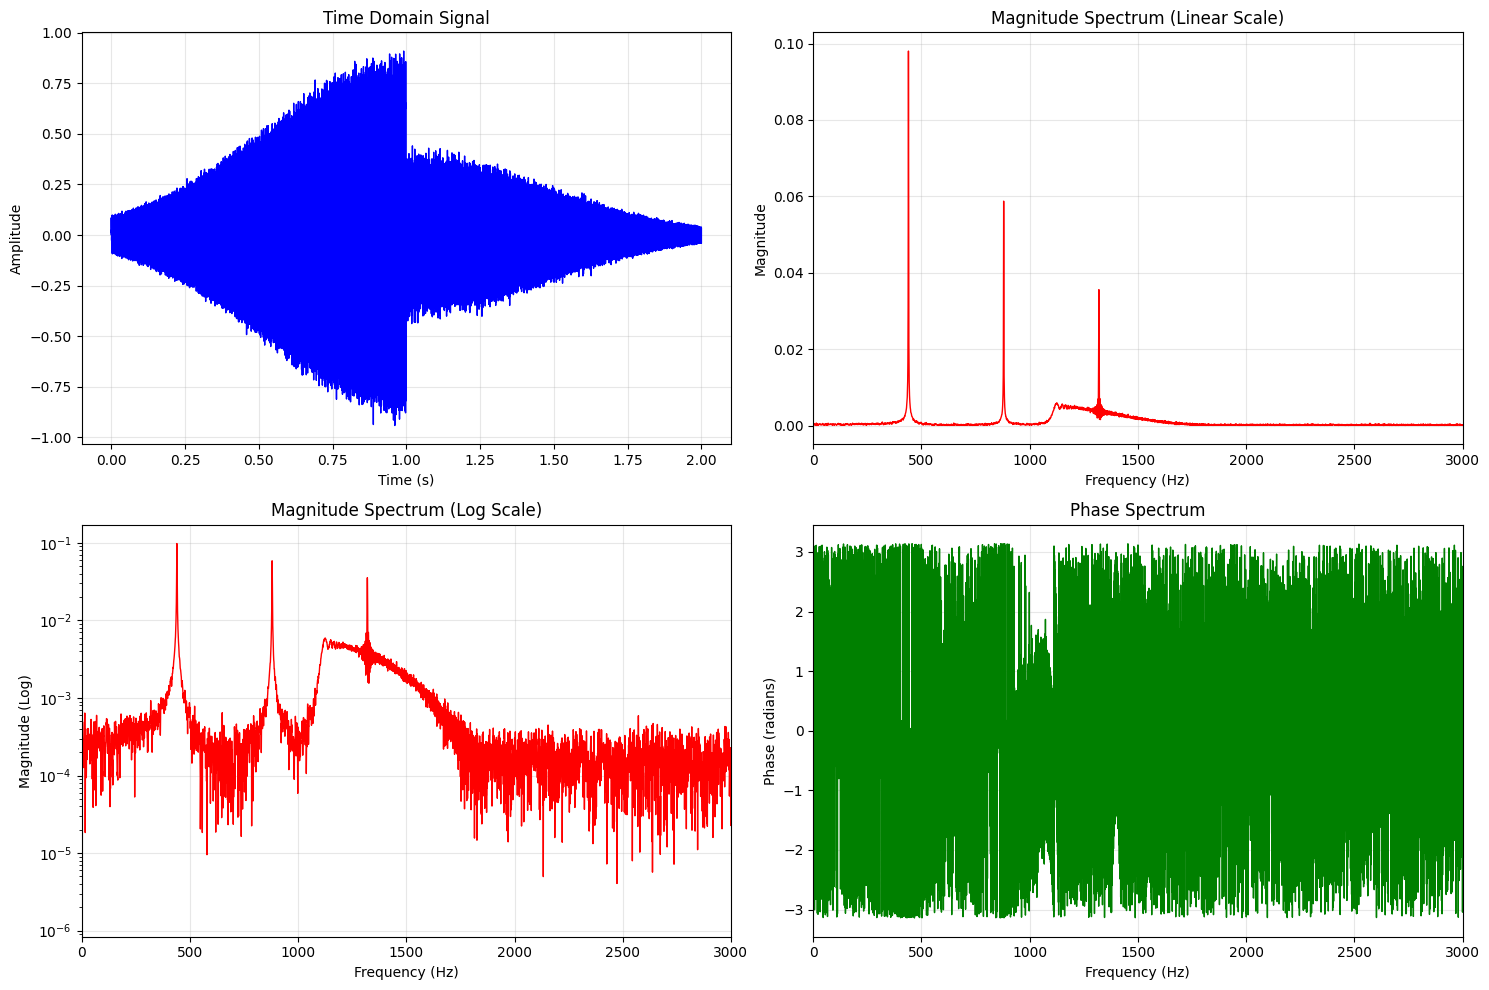


2. Computing Spectrogram...
   Time resolution: 0.0232 seconds
   Frequency resolution: 21.53 Hz
   Spectrogram shape: (1025, 88)


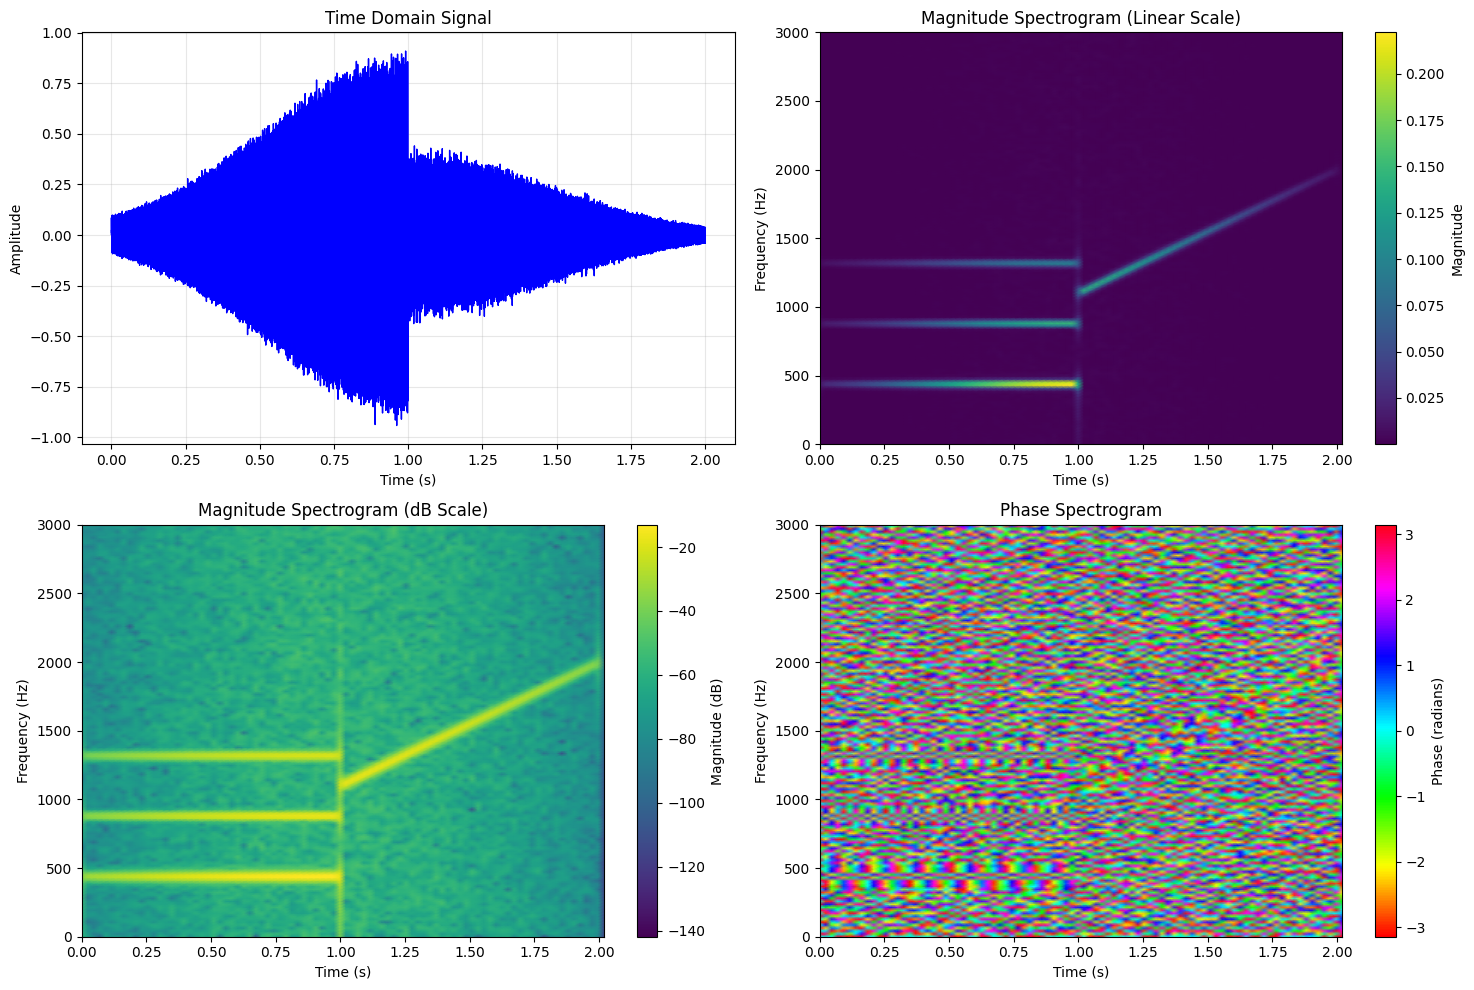


3. Computing Mel Spectrogram...
   Number of mel bins: 128
   Mel frequency range: 0.0 - 8000.0 Hz
   Mel spectrogram shape: (128, 173)


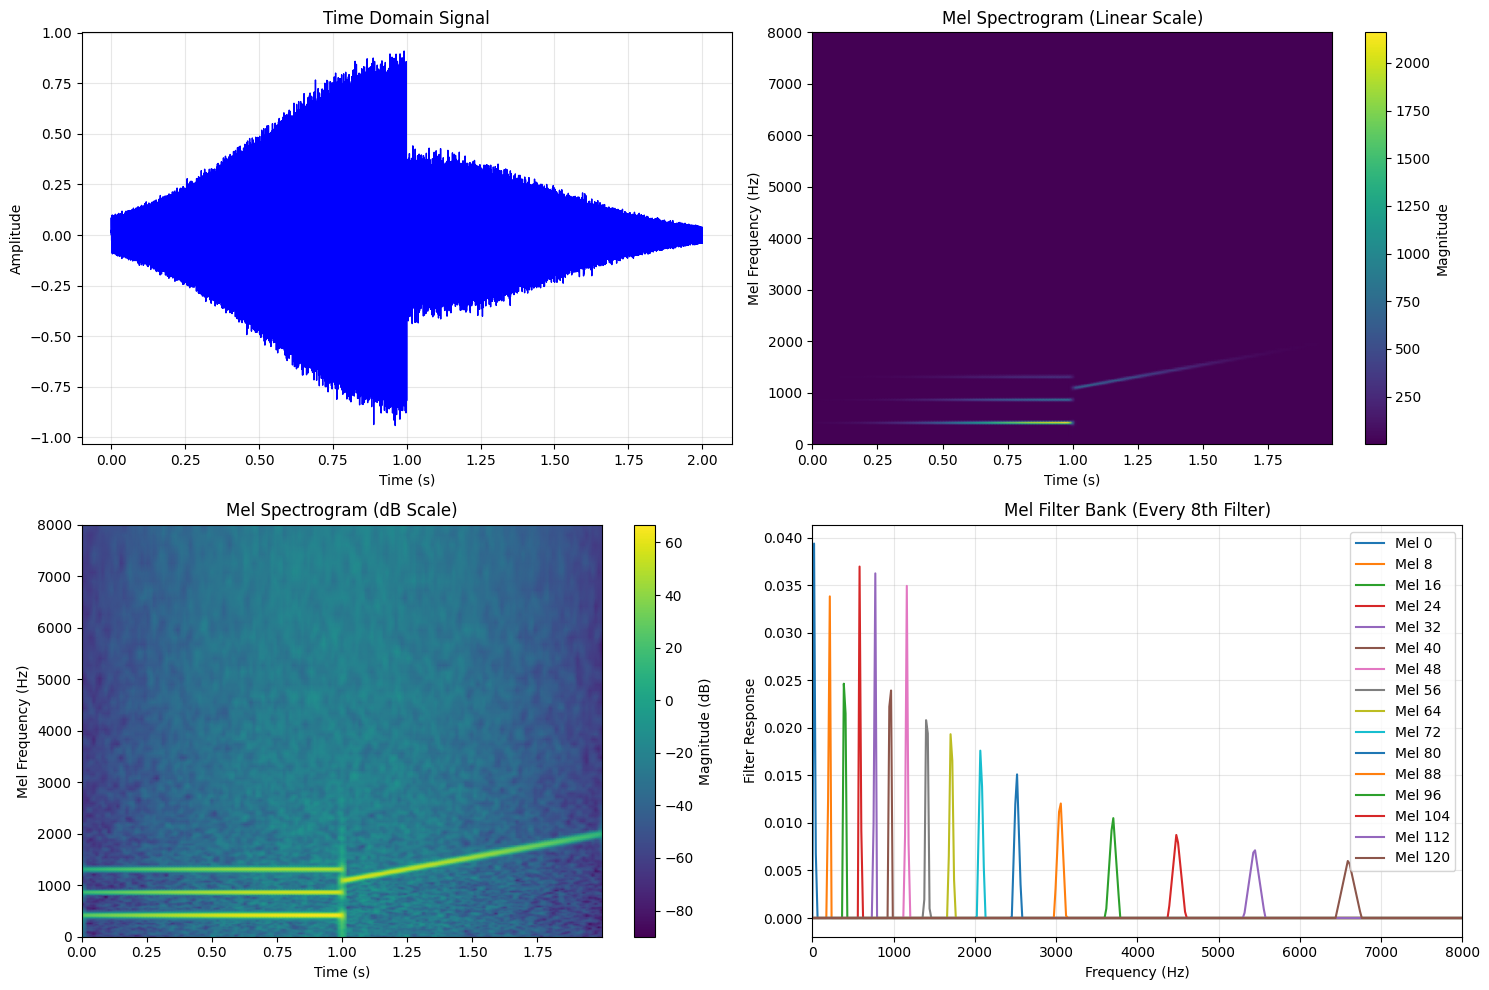


Frequency Analysis Results:
Top 5 Frequency Components (FFT):
  1. 440.0 Hz: 0.0980
  2. 439.5 Hz: 0.0842
  3. 440.5 Hz: 0.0840
  4. 880.0 Hz: 0.0587
  5. 439.0 Hz: 0.0543

Spectral Centroid: 6701.1 Hz
Peak Mel Frequency: 427.5 Hz
Total Mel Energy: 263616.57

Energy Distribution by Frequency Bands:
  Sub-bass (20-60 Hz): 0.0219
  Bass (60-250 Hz): 0.1218
  Low-mid (250-500 Hz): 1.1423
  Mid (500-2000 Hz): 4.7056
  High-mid (2-4 kHz): 0.6524
  High (4-8 kHz): 1.2493

Extracting Comprehensive Audio Features:
MFCCs shape: (13, 173)
Mean MFCCs: [-176.78913013   19.5452289     3.72406736  -10.70257488  -11.29182797
   -3.35807231    1.65108101   -0.42584262   -6.27689881   -9.9048956
   -8.10904852   -4.45897961   -3.52701462]

Spectral Contrast shape: (7, 173)
Mean Spectral Contrast: [ 8.11001115  7.73255698 19.16341864 24.68726878 16.35610934 13.32745759
 13.49719378]

Chroma shape: (12, 173)
Mean Chroma: [0.01051292 0.03564699 0.0607404  0.07667235 0.14155542 0.08395798
 0.07561389 0.08

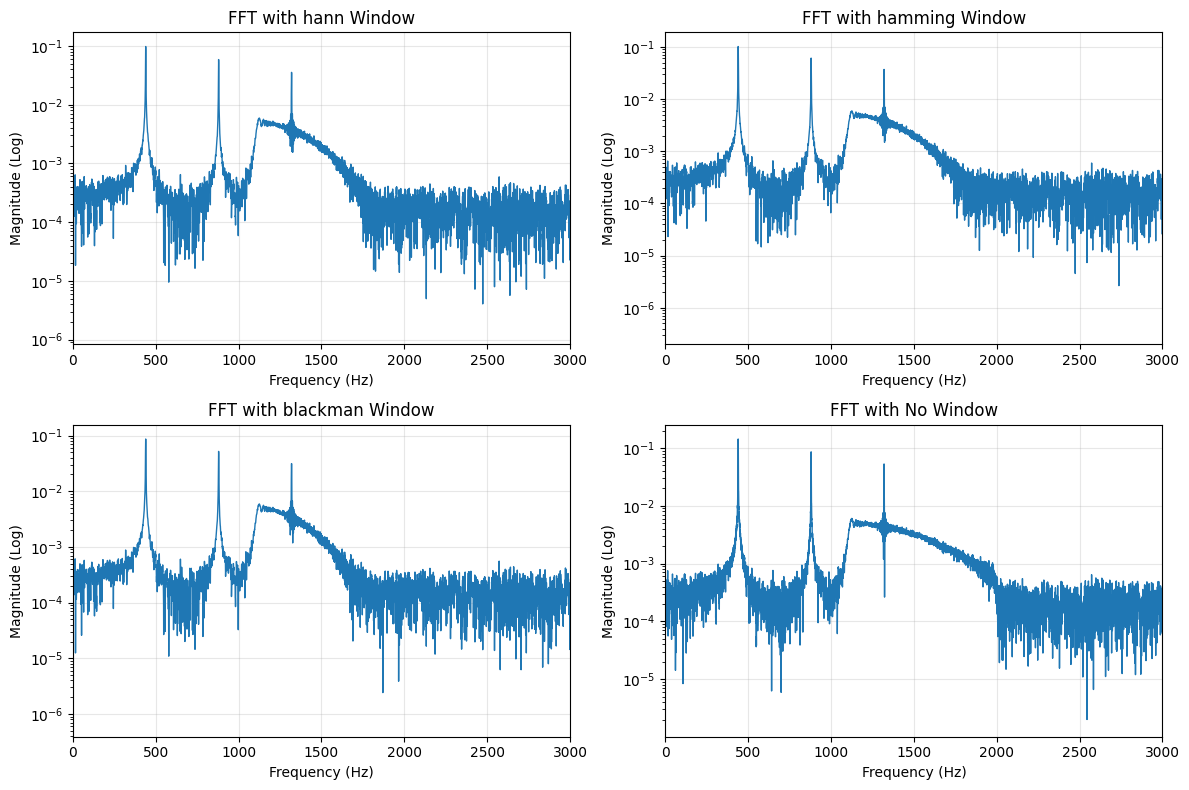

In [18]:
print("Lab 3: Frequency Domain Analysis")
print("=" * 50)
print("Analysis components:")
print("1. Fast Fourier Transform (FFT)")
print("2. Spectrogram (STFT)")
print("3. Mel Spectrogram")
print("4. Comprehensive Feature Extraction")
print("=" * 50)

# Initialize analyzer
analyzer = FrequencyDomainAnalyzer(sample_rate=44100)

# Generate test signal
print("\nGenerating complex test signal...")
test_signal, sample_rate, time_axis = generate_test_signal()

print(f"Signal duration: {len(test_signal)/sample_rate:.2f} seconds")
print(f"Sample rate: {sample_rate} Hz")
print(f"Signal length: {len(test_signal)} samples")

# 1. FFT Analysis
print("\n1. Computing FFT...")
frequencies, magnitude, phase, fft_complex = analyzer.compute_fft(
    test_signal, window='hann'
)

print(f"   Frequency resolution: {frequencies[1] - frequencies[0]:.2f} Hz")
print(f"   Number of frequency bins: {len(frequencies)}")

# Plot FFT results
plot_fft_analysis(test_signal, frequencies, magnitude, phase, sample_rate, time_axis)

# 2. Spectrogram Analysis
print("\n2. Computing Spectrogram...")
spec_frequencies, spec_times, spectrogram, phase_spectrogram, stft_complex = analyzer.compute_spectrogram(
    test_signal, nperseg=2048, noverlap=1024, window='hann'
)

print(f"   Time resolution: {spec_times[1] - spec_times[0]:.4f} seconds")
print(f"   Frequency resolution: {spec_frequencies[1] - spec_frequencies[0]:.2f} Hz")
print(f"   Spectrogram shape: {spectrogram.shape}")

# Plot spectrogram results
plot_spectrogram_analysis(test_signal, spec_frequencies, spec_times,
                        spectrogram, phase_spectrogram, sample_rate, time_axis)

# 3. Mel Spectrogram Analysis
print("\n3. Computing Mel Spectrogram...")
mel_frequencies, mel_times, mel_spec, mel_filters = analyzer.compute_mel_spectrogram(
    test_signal, n_mels=128, fmin=0, fmax=8000, n_fft=2048, hop_length=512
)

print(f"   Number of mel bins: {len(mel_frequencies)}")
print(f"   Mel frequency range: {mel_frequencies[0]:.1f} - {mel_frequencies[-1]:.1f} Hz")
print(f"   Mel spectrogram shape: {mel_spec.shape}")

# Plot mel spectrogram results
plot_mel_spectrogram_analysis(test_signal, mel_frequencies, mel_times,
                            mel_spec, mel_filters, sample_rate, time_axis)

# 4. Frequency Content Analysis
analyze_frequency_content(frequencies, magnitude, mel_frequencies, mel_spec)

# 5. Comprehensive Feature Extraction
mfccs, spectral_contrast, chroma, tempo = extract_comprehensive_features(test_signal, sample_rate)


# 6. Save results
save_spectrograms(spectrogram, mel_spec, spec_times, spec_frequencies, mel_frequencies)

print("\nLab 3 Analysis Complete!")
print("Check the generated CSV files for detailed spectrogram data.")

# Additional Analysis: Compare different window functions
print("\n" + "="*50)
print("BONUS: Window Function Comparison")
print("="*50)

windows = ['hann', 'hamming', 'blackman', None]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, window in enumerate(windows):
    freqs, mags, _, _ = analyzer.compute_fft(test_signal, window=window)
    axes[i].semilogy(freqs, mags + 1e-10, linewidth=1)
    axes[i].set_title(f'FFT with {window if window else "No"} Window')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Magnitude (Log)')
    axes[i].set_xlim(0, 3000)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def generate_test_signal_2(file_path):
    """
    Reads an audio file and returns the signal, sample rate, and time axis.
    """
    try:
        audio_signal, sample_rate = librosa.load(file_path, sr=None)
        duration = len(audio_signal) / sample_rate
        t = np.linspace(0, duration, len(audio_signal), endpoint=False)
        return audio_signal, sample_rate, t
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return None, None, None

# Example usage:
# Replace 'your_audio_file.wav' with the path to your audio file.
# You can upload a file to your Colab environment or mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = '/content/drive/MyDrive/your_audio_file.wav'

# For demonstration, let's create a dummy audio file
import soundfile as sf
dummy_signal, sr, _ = generate_test_signal()
sf.write('dummy_audio.wav', dummy_signal, sr)

test_signal_2, sample_rate_2, time_axis_2 = generate_test_signal_2('dummy_audio.wav')

if test_signal_2 is not None:
    print("Successfully loaded audio file:")
    print(f"  Duration: {len(test_signal_2)/sample_rate_2:.2f} seconds")
    print(f"  Sample rate: {sample_rate_2} Hz")
    print(f"  Signal length: {len(test_signal_2)} samples")

    # You can now use test_signal_2 for analysis, for example:
    # analyzer = FrequencyDomainAnalyzer(sample_rate=sample_rate_2)
    # freqs, mags, _, _ = analyzer.compute_fft(test_signal_2)
    # plot_fft_analysis(test_signal_2, freqs, mags, _, sample_rate_2, time_axis_2)